In [3]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import pandas as pd
import os
import sys
#from utils import *
import json
from PIL import Image
from torchvision import transforms
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)
from training.defineSNN2 import SimpleConvNet, BiggerConvNet
from prover.scorecamMOD import GetActivations,  GetMask, GetScore, GetCAM

import time
import psutil

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def cpu_time():
    return psutil.cpu_times() 

def memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss  # Resident Set Size: the non-swapped physical memory the process is using

def flush_cache():
    dummy = [i ** 2 for i in range(10**6)]
    del dummy
    torch.cuda.empty_cache()  # Clear GPU cache if using CUDA
    

Total number of parameters: 463
torch.Size([1, 1, 50, 50])
n of channel  3
Value of model outcome before sigmoid: tensor([[0.4218]])
Same class probability: tensor([[0.6039]])
Predicted Label: True
original cam:  torch.Size([50, 50])


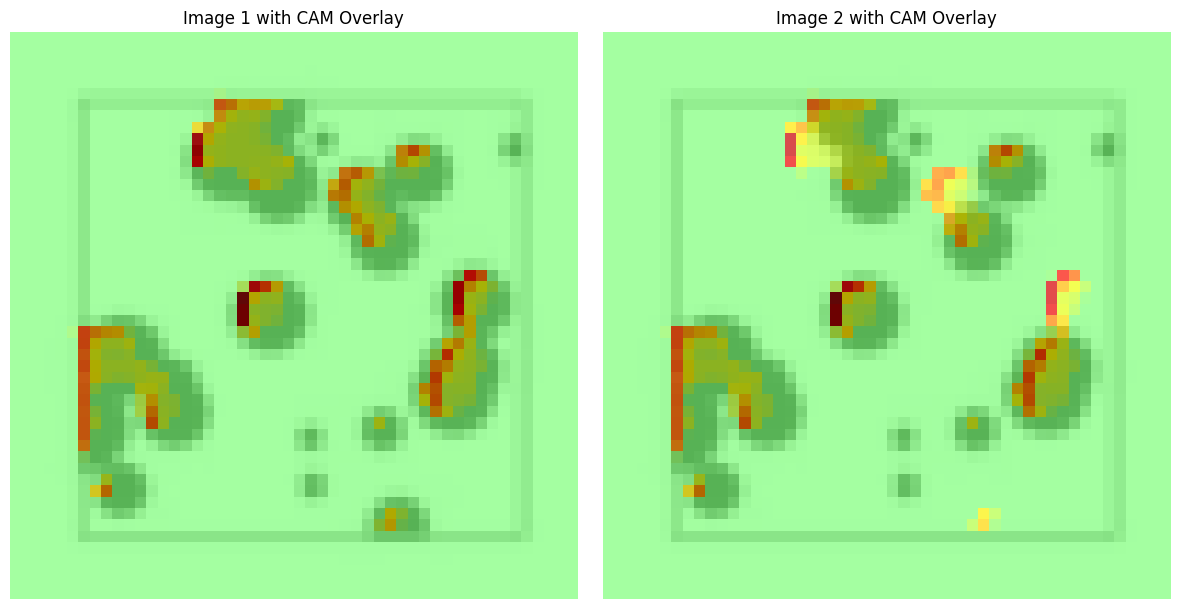

Elapsed Time: 0.55 seconds
CPU Time Used: 1.94 seconds
Memory Used: 59.89 MB


In [4]:
flush_cache()
start_time = time.time()
start_cpu = psutil.cpu_times()
start_mem = memory_usage()

########## load model to convert #############
loaded_model = SimpleConvNet().to(device)
loaded_model.load_state_dict(torch.load('training/trained__460__lr_0.001B.pth', map_location=torch.device('cpu')))


#######################
loaded_model.eval()
total_params = sum(p.numel() for p in loaded_model.parameters())
print(f'Total number of parameters: {total_params}')


target_layer = loaded_model.conv1
#target_layer = loaded_model.embedding_net.features[4]  # The last Fire module
input_size = (50, 50) 


# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
])

img1_path = "prover/TestInvalid_t0.jpeg"
img2_path = "prover/TestInvalid_t1.jpeg"
img1 = Image.open(img1_path).convert('L')
img2 = Image.open(img2_path).convert('L')
img1 = preprocess(img1).unsqueeze(0).to(device)
img2 = preprocess(img2).unsqueeze(0).to(device)
print(img1.size())


# *** Get activations and resize them ***
activations_extractor = GetActivations(loaded_model, target_layer)
activations = activations_extractor(img1, img2)
# resize activation maps
def resize_activations(activations, size):
    resized_activations = []
    for i in range(activations.size(1)):
        resized_activation = transforms.functional.resize(activations[:, i, :, :].unsqueeze(1), size).squeeze(1)
        resized_activations.append(resized_activation)
    return torch.stack(resized_activations, dim=1)

activations = resize_activations(activations, input_size)


# *** Compute Masks and Scores in loop ***
masks_generator = GetMask(activations)
scores_generator = GetScore(loaded_model)
scores_generator.eval()

all_scores = []
print("n of channel ", activations.size(1))
for index in range(activations.size(1)):  # Loop over the number of channels
    masked_input = masks_generator(img1, index)
    with torch.no_grad():
        score = scores_generator(masked_input, img2) 
    all_scores.append(score)

with torch.no_grad():
        score = loaded_model(img1, img2) # score_generator OR LOADED MODEL???
        predicted_label = (torch.sigmoid(score) > 0.5).item()
        print(f'Value of model outcome before sigmoid: {score}')
        print(f'Same class probability: {torch.sigmoid(score)}')
        print(f'Predicted Label: {predicted_label}')

# *** Compute CAM ***
cam_generator = GetCAM(activations.size(1))
stacked_scores = torch.stack(all_scores, dim=1) 
cam = cam_generator(stacked_scores, activations)
print("original cam: ", cam.size())

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_cam(cam, img1, img2, alpha=0.7, save_path='cam_overlay.png'):
    def overlay_cam_on_image(cam, img, alpha):
        if isinstance(cam, list):
            cam = np.array(cam).astype(float)
        elif isinstance(cam, np.ndarray) and cam.dtype.type is np.str_:
            cam = cam.astype(float)
        elif isinstance(cam, torch.Tensor):
            cam = cam.cpu().detach().numpy()
        cam = np.uint8(255 * cam)
        cam = np.expand_dims(cam, axis=2)
        cam = np.repeat(cam, 3, axis=2)
        cam = Image.fromarray(cam).resize((img.shape[2], img.shape[3]), Image.LANCZOS)
        cam = np.array(cam) / 255.0

        img = img.cpu().squeeze().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        
        if len(img.shape) == 2:  # Single channel image
            gray_img = np.stack([img] * 3, axis=-1)
        else:
            img = img.transpose(1, 2, 0)
            gray_img = np.dot(img, [0.2989, 0.5870, 0.1140])  # Convert to grayscale using standard coefficients
            gray_img = np.stack([gray_img] * 3, axis=-1)  # Repeat grayscale channel to match CAM

        # Adjust the colormap to display only green to red
        colormap = plt.get_cmap('jet')
        colormap = colormap(np.linspace(0.5, 1.0, 256))[:, :3]  # Take only the green to red part

        cam = cam[..., 0]
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        heatmap = colormap[(cam * 255).astype(int)]

        overlayed_img = heatmap * alpha + gray_img * (1 - alpha)
        overlayed_img = np.clip(overlayed_img, 0, 1)
        
        return overlayed_img

    overlayed_img1 = overlay_cam_on_image(cam, img1, alpha)
    overlayed_img2 = overlay_cam_on_image(cam, img2, alpha)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(overlayed_img1)
    axes[0].set_title('Image 1 with CAM Overlay')
    axes[0].axis('off')

    axes[1].imshow(overlayed_img2)
    axes[1].set_title('Image 2 with CAM Overlay')
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(save_path) 
    plt.show()

# Visualize CAM on both images and save the visualization
visualize_cam(cam, img1, img2, save_path='prover/outputs/cam_overlay.png')

end_time = time.time()
end_cpu = cpu_time()
end_mem = memory_usage()   

elapsed_time = end_time - start_time
memory_used = end_mem - start_mem
end_cpu = psutil.cpu_times()
cpu_time_used = end_cpu.user - start_cpu.user


print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"CPU Time Used: {cpu_time_used:.2f} seconds")
print(f"Memory Used: {memory_used / 1024 / 1024:.2f} MB")  

### show Quantized cam

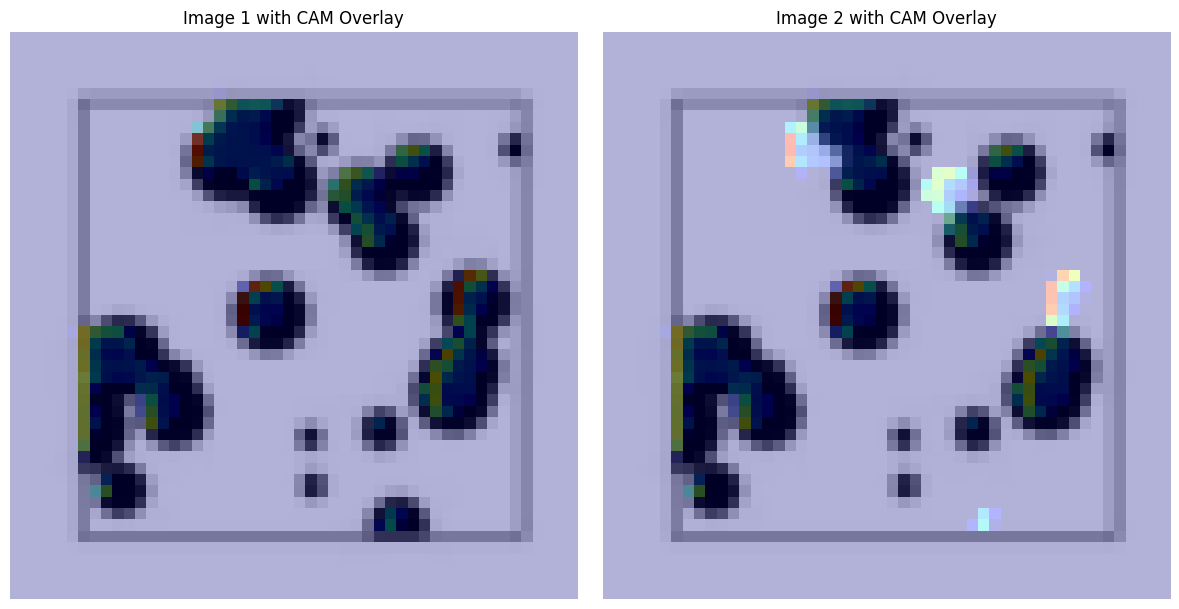

In [3]:
proof_dir = 'prover/outputs/cam/proofGetcamSINGLE460.json'
proof = json.load(open(proof_dir, 'r'))

cam_quantized = proof["pretty_public_inputs"]["rescaled_outputs"]
#cam =  torch.tensor(cam)


# Convert the list of lists to a NumPy array and then to a float array
cam_quantized_np = np.array(cam_quantized).astype(float)

# Reshape the NumPy array to the desired shape
cam_quantized_np = cam_quantized_np.reshape(50, 50)

cam_quantized_tensor = torch.tensor(cam_quantized_np)

visualize_cam(cam_quantized_tensor, img1, img2, save_path='prover/outputs/cam_overlay.png')

SHA-256 Hash CAM: 11c95c97b33609f9c34329ef812e78c0527ebae1c501b1f2fc17c57f4790abb4
SHA-256 Hash CAM Tensor: 0978a51671aeceb22f0c62a0943873067e9d9031ea309c22f1b09f11b5ed3fed
Perceptual Hash CAM: d48f4be4243b33b1
Perceptual Hash Quantized CAM: d48f4be4243b33b1


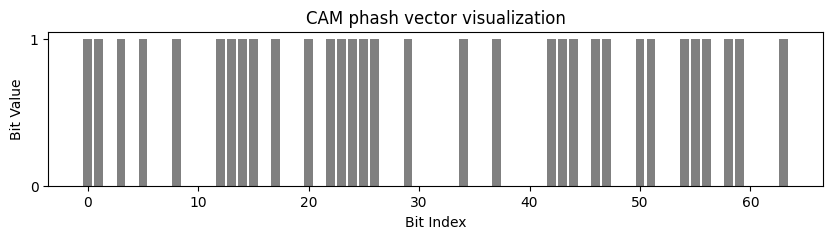

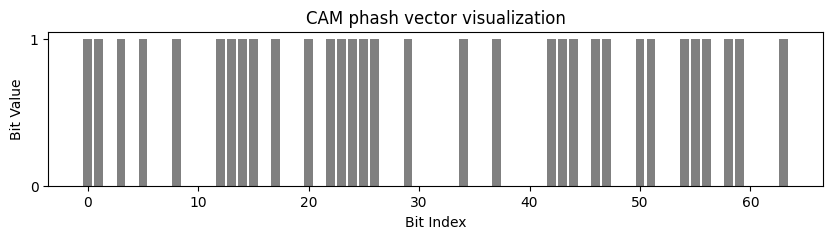

In [47]:
# Get and display PERCEPTUAL HASH of the CAM 
import imagehash
import hashlib

def compute_sha_hash(tensor):
    tensor_np = tensor.detach().cpu().numpy()
    tensor_bytes = tensor_np.tobytes()
    sha_hash = hashlib.sha256(tensor_bytes).hexdigest()
    return sha_hash

# Compute and print SHA hash for `cam`
sha_hash_cam = compute_sha_hash(cam)
print(f"SHA-256 Hash CAM: {sha_hash_cam}")

# Compute and print SHA hash for `cam_tensor`
sha_hash_cam_tensor = compute_sha_hash(cam_quantized_tensor)
print(f"SHA-256 Hash CAM Tensor: {sha_hash_cam_tensor}")

def display_phash_as_vector(phash):
    # Convert the perceptual hash to a bit array
    bits = np.array(phash.hash, dtype=np.uint8).flatten()
    
    # Display the bit array as a bar plot
    plt.figure(figsize=(10, 2))
    plt.bar(range(len(bits)), bits, color='gray')
    plt.title('CAM phash vector visualization')
    plt.xlabel('Bit Index')
    plt.ylabel('Bit Value')
    plt.yticks([0, 1]) 
    plt.show()

# Assuming `cam` is a PyTorch tensor containing your CAM data
cam_np = cam.detach().cpu().numpy()
cam_np = (cam_np * 255).astype(np.uint8)  # Convert to uint8 format
cam_image = Image.fromarray(cam_np)
perceptual_hash = imagehash.phash(cam_image)
print(f"Perceptual Hash CAM: {perceptual_hash}")

cam_np = cam_quantized_tensor.detach().cpu().numpy()
cam_np = (cam_np * 255).astype(np.uint8)  # Convert to uint8 format
cam_image = Image.fromarray(cam_np)
perceptual_hash2 = imagehash.phash(cam_image)
print(f"Perceptual Hash Quantized CAM: {perceptual_hash}")

# Display the perceptual hash
display_phash_as_vector(perceptual_hash)
display_phash_as_vector(perceptual_hash2)



    